In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy
import numpy as np
import pandas as pd
import os

data_folder = '/content/drive/MyDrive/data/'

ads = pd.read_csv(os.path.join(data_folder, 'ads.csv'))
ads.head()

,cpm,hour_start,hour_end,publishers,audience_size,user_ids,ad_id
0,220.0,1058,1153,"7,17",1906,"12,44,46,50,58,71,93,122,134,143,176,184,187,1...",0
1,312.0,1295,1301,"3,18",1380,"29,81,98,102,165,167,195,205,218,231,242,263,3...",1
2,70.0,1229,1249,"1,2,3,9,15,21",888,"12,23,25,29,45,85,92,124,156,190,272,334,456,5...",2
3,240.0,1295,1377,"1,14",440,"44,122,187,209,242,255,312,345,382,465,513,524...",3
4,262.0,752,990,"1,3,7,8",1476,"15,24,30,43,50,53,96,105,159,168,181,190,196,2...",4


In [ ]:
history = pd.read_csv(os.path.join(data_folder,'history.csv'))
history.head()

,hour,cpm,publisher,user_id
0,10,30.00,1,15661
1,8,41.26,1,8444
2,7,360.00,1,15821
3,18,370.00,1,21530
4,8,195.00,2,22148


In [ ]:
target = pd.read_csv(os.path.join(data_folder,'target.csv'))
target.head()

,ad_id,at_least_one
0,0,0.0430
1,1,0.0130
2,2,0.0878
3,3,0.2295
4,4,0.3963


In [ ]:
users = pd.read_csv(os.path.join(data_folder, 'users.csv'))
users.head()

,user_id,sex,age,city_id
0,0,2,19,0
1,1,1,0,1
2,2,2,24,2
3,3,1,20,3
4,4,2,29,4


In [ ]:
users.shape

(27769, 4)

In [ ]:
users = users.replace(0, numpy.NaN)
users.head()

,user_id,sex,age,city_id
0,NaN,2.0,19.0,NaN
1,1.0,1.0,NaN,1.0
2,2.0,2.0,24.0,2.0
3,3.0,1.0,20.0,3.0
4,4.0,2.0,29.0,4.0


In [ ]:
users.isnull().sum(axis=0)

user_id       1
sex          30
age        2180
city_id    8479
dtype: int64

In [ ]:
sample = pd.read_csv(os.path.join(data_folder, 'sample_solution.csv'))
sample.head()

,ad_id,at_least_one
0,700,0.118536
1,701,0.118536
2,702,0.118536
3,703,0.118536
4,704,0.118536


In [ ]:
from scipy import stats

users['sex'] = users['sex'].fillna(stats.mode(users['sex']).mode[0])
users['age'] = users['age'].fillna(np.mean(users['age']))
users['city_id'] = users['city_id'].fillna(stats.mode(users['city_id']).mode[0])
users.shape

(27769, 4)

## Анализ истории

In [ ]:
# Какой трафик на каждой платформе?

# Посчитаем для каждого часа: сколько постов было на каждой платформе?

n_publishers = len(history.publisher.unique())
posts_per_hour_by_publishers = []
TAKE_FIRST_N_HOURS = 24 * 4

for hour, hour_data in history[history.hour < TAKE_FIRST_N_HOURS].groupby('hour'):
    publishers_posts = hour_data.value_counts('publisher')
    
    counts = [0 for _ in range(n_publishers)]
    for pub_id, posts_n in list(publishers_posts.items()):
        counts[pub_id-1] = posts_n
        
    posts_per_hour_by_publishers.append([hour] + counts)

    
df = pd.DataFrame.from_records(posts_per_hour_by_publishers, columns=['hour'] + list(history.publisher.unique()))
df.head()

,hour,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,21,20
0,3,100,67,11,1,3,1,7,0,2,0,1,0,0,0,0,2,1,0,0,0,0
1,4,173,51,10,0,1,1,11,1,2,0,0,1,0,0,0,1,0,0,0,0,0
2,5,246,91,21,1,1,4,12,3,2,1,0,2,1,0,0,0,0,0,0,0,0
3,6,346,95,27,2,0,5,16,1,4,4,1,0,0,0,0,1,1,0,0,0,0
4,7,488,157,29,2,5,5,42,3,6,2,4,0,0,0,0,0,0,0,0,0,0


Text(0, 0.5, 'Количество постов')

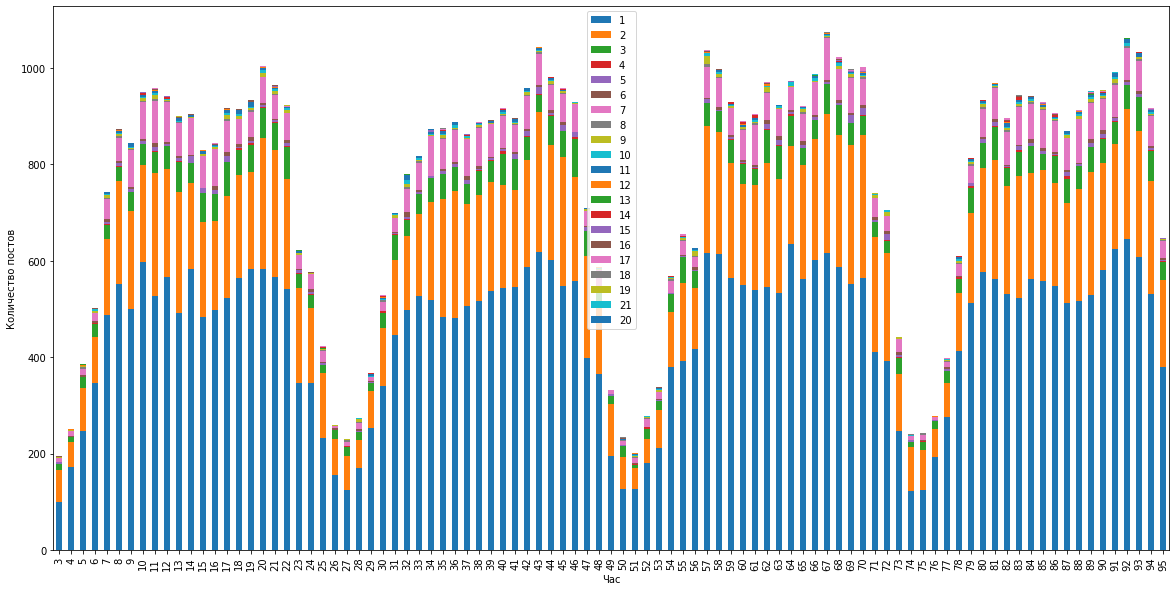

In [ ]:
import matplotlib.pyplot as plt

df.plot.bar(x='hour', stacked=True, figsize=(20, 10))
plt.xlabel('Час')
plt.ylabel('Количество постов')

По графику очевидно, что пиковое время это 8.00 - 22.00

In [ ]:
ads = ads.assign(
    duration=ads.hour_end - ads.hour_start,
    n_publishers=ads.publishers.apply(lambda s: len(s.split(',')))
)
ads = ads.assign(
    dur_x_audience=ads.duration*ads.audience_size,
    log_dur_x_audience=np.log(ads.duration*ads.audience_size),
    cpm_x_duration=ads.cpm*ads.duration
)

start = ads.hour_start.to_numpy()
end = ads.hour_end.to_numpy()

def gen_peak_series(start, end):
    res = np.array([])
    for i in range(len(start)):
        res = np.append(res, peak(start[i],end[i]))
    return res

def peak(start, end):
    st = start % 24
    en = end % 24
    days = ((end - en) - (start - st) - 1) // 24
    return days * 14 + max(0, 22 - max(st, 8)) + max(0, min(en, 22) - 8)

ads = ads.assign(peek_hours= pd.Series(gen_peak_series(start,end)))

ads = ads.drop(['hour_start', 'hour_end', 'publishers'], axis=1)
ads.head()

,cpm,audience_size,user_ids,ad_id,duration,n_publishers,dur_x_audience,log_dur_x_audience,cpm_x_duration,peek_hours
0,220.0,1906,"12,44,46,50,58,71,93,122,134,143,176,184,187,1...",0,95,2,181070,12.106639,20900.0,56.0
1,312.0,1380,"29,81,98,102,165,167,195,205,218,231,242,263,3...",1,6,2,8280,9.021598,1872.0,0.0
2,70.0,888,"12,23,25,29,45,85,92,124,156,190,272,334,456,5...",2,20,6,17760,9.784704,1400.0,14.0
3,240.0,440,"44,122,187,209,242,255,312,345,382,465,513,524...",3,82,2,36080,10.493494,19680.0,43.0
4,262.0,1476,"15,24,30,43,50,53,96,105,159,168,181,190,196,2...",4,238,4,351288,12.769362,62356.0,140.0


In [ ]:
dim1, dim2 = ads.shape

ads['mode_sex'] = np.zeros_like(dim2)
ads['mean_age'] = np.zeros_like(dim2)
ads['mode_city'] = np.zeros_like(dim2)

for id, us in zip(ads['ad_id'].values, ads['user_ids'].values):
    user_ids = [int(i) for i in us.split(',')]
    u_data = [(user['sex'], user['age'], user['city_id']) for user in [users.loc[users['user_id'] == u_id] for u_id in user_ids] if not user.empty]
    sex, age, city = zip(*u_data)
    ads.loc[ads['ad_id'] == id, 'mean_age'] = np.mean(age)
    ads.loc[ads['ad_id'] == id, 'mode_sex'] = stats.mode(sex).mode[0]
    ads.loc[ads['ad_id'] == id, 'mode_city'] = stats.mode(city).mode[0]
ads.head()

ads.to_csv('new_ads.csv', index=False)

In [ ]:
ads = pd.read_csv('new_ads.csv')

In [ ]:
target.shape

(700, 2)

In [ ]:
ads.shape

(1008, 15)

In [ ]:
train = pd.merge(ads, target, on='ad_id')
train.drop(['user_ids'], axis=1, inplace=True)
train.head()

,cpm,audience_size,ad_id,duration,n_publishers,dur_x_audience,log_dur_x_audience,cpm_x_duration,peek_hours,mode_sex,mean_age,mode_city,at_least_one
0,220.0,1906,0,95,2,181070,12.106639,20900.0,56.0,1.0,30.728484,25.0,0.0430
1,312.0,1380,1,6,2,8280,9.021598,1872.0,0.0,1.0,30.111252,3.0,0.0130
2,70.0,888,2,20,6,17760,9.784704,1400.0,14.0,1.0,31.385729,3.0,0.0878
3,240.0,440,3,82,2,36080,10.493494,19680.0,43.0,1.0,29.972843,19.0,0.2295
4,262.0,1476,4,238,4,351288,12.769362,62356.0,140.0,1.0,44.760840,3.0,0.3963


In [ ]:
train.shape

(700, 15)

In [ ]:
from sklearn.model_selection import train_test_split

X = train.drop(['ad_id', 'at_least_one'], axis=1)
y = train['at_least_one']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
!pip install catboost
from catboost import CatBoostRegressor
classy = CatBoostRegressor()
classy.fit(X_train, y_train)
predicted = classy.predict(X_val)

     |████████████████████████████████| 76.3 MB 22.2 MB/s 
Learning rate set to 0.037359
0:	learn: 0.1424555	total: 49.3ms	remaining: 49.3s
1:	learn: 0.1405269	total: 51.7ms	remaining: 25.8s
2:	learn: 0.1385368	total: 54.4ms	remaining: 18.1s
3:	learn: 0.1367695	total: 56.6ms	remaining: 14.1s
4:	learn: 0.1351149	total: 58.9ms	remaining: 11.7s
5:	learn: 0.1335393	total: 61.7ms	remaining: 10.2s
6:	learn: 0.1321249	total: 64.4ms	remaining: 9.14s
7:	learn: 0.1307124	total: 67.4ms	remaining: 8.36s
8:	learn: 0.1291670	total: 69.9ms	remaining: 7.69s
9:	learn: 0.1278341	total: 72.1ms	remaining: 7.14s
10:	learn: 0.1265793	total: 75ms	remaining: 6.74s
11:	learn: 0.1253862	total: 77.8ms	remaining: 6.4s
12:	learn: 0.1242058	total: 80.5ms	remaining: 6.11s
13:	learn: 0.1231204	total: 82.7ms	remaining: 5.83s
14:	learn: 0.1220060	total: 85ms	remaining: 5.58s
15:	learn: 0.1208427	total: 87.4ms	remaining: 5.37s
16:	learn: 0.1198148	total: 90.5ms	remaining: 5.23s
17:	learn: 0.1186659	total: 93ms	remaining

In [ ]:
X_test = ads.loc[ads['ad_id'] >= 700].drop(['user_ids'], axis=1)
X_test.head()

,cpm,audience_size,ad_id,duration,n_publishers,dur_x_audience,log_dur_x_audience,cpm_x_duration,peek_hours,mode_sex,mean_age,mode_city,one/two,two/one
700,330.0,344,700,5,4,1720,7.450080,1650.0,5.0,1.0,30.780685,3.0,0,0
701,79.0,1960,701,151,3,295960,12.597980,11929.0,86.0,1.0,31.759283,3.0,0,0
702,130.0,2400,702,5,3,12000,9.392662,650.0,5.0,1.0,30.944892,3.0,0,0
703,134.0,1960,703,3,5,5880,8.679312,402.0,0.0,1.0,31.393400,3.0,0,0
704,50.0,1428,704,30,4,42840,10.665228,1500.0,14.0,1.0,33.966036,3.0,0,0


In [ ]:
sample['at_least_one'] = classy.predict(X_test.drop('ad_id',axis=1, inplace=False))
sample.head()

,ad_id,at_least_one
0,700,0.071257
1,701,0.139371
2,702,0.036924
3,703,0.018071
4,704,0.009255


In [ ]:
sample.to_csv('submission.csv', index=False)